# Робота №4. Вивчення структури металів за допомогою функції радіального розподілу атомів

## Мета роботи
Дослідження параметрів структури металів в кристалічному та рідкому стані за допомогою визначення ФРР атомів моделюванням методом молекулярної динаміки.

## Об'єкт дослідження
Чисті метали за умов різних температур.

## Устаткування, прилади та матеріали

In [48]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

def read_data(name):
    data_frame = pd.read_csv(name, delimiter='\s+', skipinitialspace=True, skiprows=4,
                             names=['skip1', 'HETATM', 'type', 'X', 'Y', 'Z'])[['X', 'Y', 'Z']]
    data_frame.dropna(inplace=True)
    return data_frame

def read_rdf(name):
    data_frame = pd.read_csv(name, delimiter='\s+', skipinitialspace=True, skiprows=1,
                             names=['X', 'count', 'cummulative'], index_col='X')
    return data_frame

## Програма проведення експерименту
Створити кристал з ~1000-2000 атомів з періодичними граничними умовами. Матеріал: Pt.

In [1]:
%%writefile lab4.xm
read ../pot/Pt_xmd.eam

box 9 9 9

fill particle 4
1     0.0        0.0        0.0
1     0.5        0.0        0.5
1     0.5        0.5        0.0
1     0.0        0.5        0.5

fill align 8 8 8
fill orient 1 0 0  0 1 0  0 0 1
fill go

dtime 1e-14

select all #
mass 195.084

clamp $1
itemp $1
scale 3.9231

select index 14571
set add 1
select keep on

cmd 1000
#write file +lab2_pos_vel_$1.txt sel posvel
write pdb +lab4_$2.pdb
#WRITE file +lab4_$2.rdf RDF 160 2 18

Overwriting lab4.xm


Задаємо температуру плавлення Pt, та розрахункових температур:

In [1]:
Tmelt = 2041.4 # Kelvin
T = [0.1*Tmelt, 1.5*Tmelt]

Релаксувуємо матеріал при температурах 0.1 і 1.5T<sub>пл</sub>.

In [3]:
for i, temp in enumerate(T):
    !del /f lab4_{i}.pdb
    #!del /f lab4_{i}.rdf
    !xmd lab4.xm {temp} {i} > lab4_{i}.log # temperature, n of experiment

Зчитуємо координати атомів:

In [52]:
data = [read_data(f'lab4_{i}.pdb') for i in range(2)]

## Опрацювання результатів експерименту

Розрахувати нові координати атомів, використовуючи положення обраного атома
поблизу центру розрахункової комірки за початок координат.

In [53]:
centre = data[0].iloc[1456]

for i in range(2):
    for axis in ['X', 'Y', 'Z']:
        data[i][axis] = data[i][axis] - centre[axis]
    data[i]['distance'] = np.sqrt(data[i].X ** 2 + data[i].Y ** 2 + data[i].Z **2)

Побудувати гістограму розподілу атомів за відстанню до 7 А з інтервалом 0,1 А для
температур T=0,1 і 1,5T<sub>пл</sub>, виходячи з координат атомів.

In [130]:
len(bins), len(counts)

(71, 70)

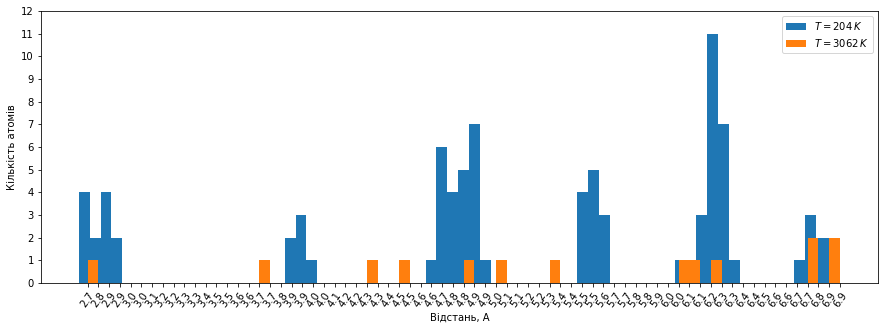

In [169]:
fig, ax = plt.subplots(figsize=(15, 5))
df = [pd.DataFrame(), pd.DataFrame()]
for i in range(2):
    counts, bins, patches = ax.hist(data[i].distance[(data[i].distance < 7) & (data[i].distance > 2)],
                                    bins=70, label=f'$T = {T[i]:.0f}\,K$')
    df[i]['X'] = bins[1:]
    df[i]['counts'] = counts

ax.legend()
# Set the ticks to be at the edges of the bins.
ax.set_yticks(np.linspace(0, 12, 13))
ax.set_xticks(bins, minor=False)
ax.set_xticklabels(np.round(bins, 1), rotation=55)
ax.grid(False)
ax.set_xlabel('Відстань, А')
ax.set_ylabel('Кількість атомів')

Аналогічну функцію побудови гістограми в XMD виконує команда RDF. 

In [72]:
rdf = [read_rdf(f'lab4_{i}.rdf') for i in range(2)]

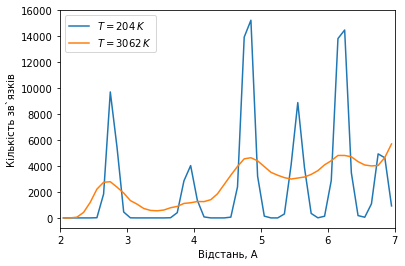

In [161]:
for i in range(2):
    rdf[i]['norm_count'] = rdf[i]['count']
    ax1 = rdf[i]['norm_count'][rdf[i].index < 7].plot(label=f'$T = {T[i]:.0f}\,K$')

ax1.legend()
ax1.set_xticks(np.arange(2, 8))
ax1.set_xlabel('Відстань, А')
ax1.set_ylabel("Кількість зв`язків")

Побудувати ФРРА за формулами

$$\rho = \frac{dn}{4\pi r^2\, dr}$$

та

$$g(r) = \frac{V}{N} \rho(r) = \frac{1}{\rho_{\textit{ат}}} \rho(r)$$

Величини $dn$ взяти з попереднього пункту, як і $dr=0.5\,A$.

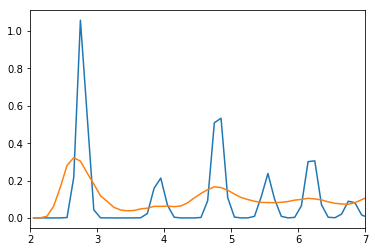

In [155]:
for i in range(2):
    rdf[i]['rho'] = rdf[i].norm_count / (4 * np.pi * rdf[i].index ** 2 * 0.5)
    rdf[i]['g'] = rdf[i]['rho'] * (V/N)
    plt.plot(rdf[i].index, rdf[i]['g'])
    plt.xlim((2, 7))

Знайти координаційні числа для кристалу і рідини в трьох перших координаційних сферах.

In [158]:
rdf[0]

,count,cummulative,norm_count,rho,g
X,,,,,
2.05,0,0,0.000000,0.000000,0.000000
2.15,0,0,0.000000,0.000000,0.000000
2.25,0,0,0.000000,0.000000,0.000000
2.35,0,0,0.000000,0.000000,0.000000
2.45,0,0,0.000000,0.000000,0.000000
2.55,15,15,0.005144,0.000126,0.001901
2.65,1840,1855,0.631001,0.014301,0.215867
2.75,9715,11570,3.331619,0.070115,1.058372
2.85,5463,17033,1.873457,0.036709,0.554118


Знайти відстані до атомів в цих сферах.

Порівняти щільність пакування атомів в різних типах ґраток і рідині, та їх густину.

Пояснити, як узгоджуються ФРР і розташування дифракційних ліній на рентгенограмах.